In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df_raw = pd.read_csv("wdbc.csv", header=None)

y = pd.get_dummies(df_raw.iloc[:,1:2])

x = df_raw.iloc[:,2:]
x = (x - x.min()) / (x.max() - x.min())

#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

y_train = torch.Tensor(y_train.values)
x_train = torch.Tensor(x_train.values)
print(df_raw)
print(y)
#y_train


           0  1      2      3       4       5        6        7        8   \
0      842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.30010   
1      842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.08690   
2    84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.19740   
3    84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.24140   
4    84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.19800   
..        ... ..    ...    ...     ...     ...      ...      ...      ...   
564    926424  M  21.56  22.39  142.00  1479.0  0.11100  0.11590  0.24390   
565    926682  M  20.13  28.25  131.20  1261.0  0.09780  0.10340  0.14400   
566    926954  M  16.60  28.08  108.30   858.1  0.08455  0.10230  0.09251   
567    927241  M  20.60  29.33  140.10  1265.0  0.11780  0.27700  0.35140   
568     92751  B   7.76  24.54   47.92   181.0  0.05263  0.04362  0.00000   

          9   ...      22     23      24      25       26       27      28 

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 20) # input to first hidden layer
        self.hidden_layer_2 = nn.Linear(20, 10)               
        
        self.multiple_layers = nn.Sequential(
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
        )
        
        self.output_layer = nn.Linear(10, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.activation(x)
        
        x = self.hidden_layer_2(x)
        x = self.activation(x)        
        
        
        x = self.multiple_layers(x)
        
        y = self.output_layer(x)
        y = self.activation(y)
        
        return y

In [4]:
model = NeuralNetwork(30, 2)

# Test structure of model
predictions = model.forward(x_train)
# preds = predictions.detach().cpu().numpy()

# ohe = []
# for i in preds:
#        if i[0] > i[1]:
#              ohe.append([1,0])
#        else:
#              ohe.append([0,1])

# ohe

In [5]:
#learning_rate = 0.00001 #63%
learning_rate = 0.0001 #93%
#learning_rate = 0.1 #63%

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 5

In [6]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [7]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset(x=x_train, y=y_train)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    #state = { 'state_dict': model.state_dict() }

    #torch.save(state, "model.pth")

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 272.94it/s, loss=0.257]


Ave Loss: 0.25700563099235296
Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 276.10it/s, loss=0.254]


Ave Loss: 0.25446388926357033
Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 293.38it/s, loss=0.251]


Ave Loss: 0.25218457393348215
Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 291.36it/s, loss=0.249]


Ave Loss: 0.2501386895775795
Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 276.74it/s, loss=0.246]


Ave Loss: 0.24830413926392794
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 299.39it/s, loss=0.244]


Ave Loss: 0.24666111990809442
Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 296.68it/s, loss=0.242]


Ave Loss: 0.24519182164222003
Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 293.73it/s, loss=0.241]


Ave Loss: 0.2438800936564803
Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 288.69it/s, loss=0.239]


Ave Loss: 0.2427112851291895
Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 295.94it/s, loss=0.238]


Ave Loss: 0.24167201425880194
Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 283.76it/s, loss=0.236]


Ave Loss: 0.24074994772672653
Epoch: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 292.53it/s, loss=0.235]


Ave Loss: 0.2399336513131857
Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 298.29it/s, loss=0.234]


Ave Loss: 0.23921251073479652
Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 275.02it/s, loss=0.233]


Ave Loss: 0.23857669327408076
Epoch: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 293.98it/s, loss=0.232]


Ave Loss: 0.2380171462893486
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 295.00it/s, loss=0.231]


Ave Loss: 0.23752556089311838
Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 287.20it/s, loss=0.231]


Ave Loss: 0.2370943421497941
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 288.96it/s, loss=0.23]


Ave Loss: 0.23671661429107188
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 304.02it/s, loss=0.23]


Ave Loss: 0.23638615477830172
Epoch: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 316.15it/s, loss=0.229]


Ave Loss: 0.2360973697155714
Epoch: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 324.49it/s, loss=0.229]


Ave Loss: 0.23584525417536498
Epoch: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 320.82it/s, loss=0.228]


Ave Loss: 0.2356253432109952
Epoch: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 315.28it/s, loss=0.228]


Ave Loss: 0.23543366715312003
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 299.24it/s, loss=0.227]


Ave Loss: 0.23526671007275582
Epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 321.50it/s, loss=0.227]


Ave Loss: 0.23512136712670326
Epoch: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 310.28it/s, loss=0.227]


Ave Loss: 0.23499489333480597
Epoch: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 322.58it/s, loss=0.227]


Ave Loss: 0.234884886816144
Epoch: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 322.13it/s, loss=0.226]


Ave Loss: 0.23478922788053752
Epoch: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 325.12it/s, loss=0.226]


Ave Loss: 0.23470607437193394
Epoch: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 325.44it/s, loss=0.226]


Ave Loss: 0.2346337992697954
Epoch: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 327.21it/s, loss=0.226]


Ave Loss: 0.23457097299396992
Epoch: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 324.77it/s, loss=0.226]


Ave Loss: 0.2345163756981492
Epoch: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 319.44it/s, loss=0.225]


Ave Loss: 0.23446891736239195
Epoch: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 323.29it/s, loss=0.225]


Ave Loss: 0.2344276549294591
Epoch: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 319.43it/s, loss=0.225]


Ave Loss: 0.23439177349209786
Epoch: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 313.05it/s, loss=0.225]


Ave Loss: 0.2343605563044548
Epoch: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 298.33it/s, loss=0.225]


Ave Loss: 0.23433338459581138
Epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 324.30it/s, loss=0.225]


Ave Loss: 0.23430971018970012
Epoch: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 317.20it/s, loss=0.225]


Ave Loss: 0.23428906612098216
Epoch: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 317.39it/s, loss=0.225]


Ave Loss: 0.2342710504308343
Epoch: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 315.20it/s, loss=0.225]


Ave Loss: 0.2342552922666073
Epoch: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 322.48it/s, loss=0.225]


Ave Loss: 0.23424150366336108
Epoch: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 317.19it/s, loss=0.225]


Ave Loss: 0.23422939982265234
Epoch: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 315.79it/s, loss=0.225]


Ave Loss: 0.2342187574133277
Epoch: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 320.00it/s, loss=0.224]


Ave Loss: 0.23420936986804008
Epoch: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 328.51it/s, loss=0.224]


Ave Loss: 0.234201068431139
Epoch: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 315.78it/s, loss=0.224]


Ave Loss: 0.23419369738548995
Epoch: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 310.10it/s, loss=0.224]


Ave Loss: 0.23418712448328732
Epoch: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 326.09it/s, loss=0.224]


Ave Loss: 0.23418123759329318
Epoch: 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 315.16it/s, loss=0.224]


Ave Loss: 0.23417594283819199
Epoch: 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 313.41it/s, loss=0.224]


Ave Loss: 0.2341711524873972
Epoch: 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 303.33it/s, loss=0.224]


Ave Loss: 0.234166787751019
Epoch: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 318.43it/s, loss=0.224]


Ave Loss: 0.23416278809309005
Epoch: 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 319.18it/s, loss=0.224]


Ave Loss: 0.2341591063886881
Epoch: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 318.23it/s, loss=0.224]


Ave Loss: 0.23415567632764578
Epoch: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 325.48it/s, loss=0.224]


Ave Loss: 0.23415247965604066
Epoch: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 321.99it/s, loss=0.224]


Ave Loss: 0.23414946403354406
Epoch: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 328.28it/s, loss=0.224]


Ave Loss: 0.23414660356938838
Epoch: 58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 317.98it/s, loss=0.224]


Ave Loss: 0.23414386659860612
Epoch: 59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 323.52it/s, loss=0.224]


Ave Loss: 0.23414123933762312
Epoch: 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 314.68it/s, loss=0.224]


Ave Loss: 0.23413869366049767
Epoch: 61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 325.54it/s, loss=0.224]


Ave Loss: 0.23413621373474597
Epoch: 62


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 319.64it/s, loss=0.224]


Ave Loss: 0.23413377832621335
Epoch: 63


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 320.92it/s, loss=0.224]


Ave Loss: 0.2341313872486353
Epoch: 64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 309.22it/s, loss=0.224]


Ave Loss: 0.23412902150303125
Epoch: 65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 317.90it/s, loss=0.224]


Ave Loss: 0.23412667587399483
Epoch: 66


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 309.63it/s, loss=0.224]


Ave Loss: 0.23412432949990034
Epoch: 67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 309.14it/s, loss=0.224]


Ave Loss: 0.23412198815494775
Epoch: 68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 312.57it/s, loss=0.224]


Ave Loss: 0.23411963935941457
Epoch: 69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 322.56it/s, loss=0.224]


Ave Loss: 0.23411727398633958
Epoch: 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 317.84it/s, loss=0.224]


Ave Loss: 0.234114889241755
Epoch: 71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 310.74it/s, loss=0.224]


Ave Loss: 0.2341124864295125
Epoch: 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 318.25it/s, loss=0.224]


Ave Loss: 0.23411005306988955
Epoch: 73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 318.52it/s, loss=0.224]


Ave Loss: 0.23410759177058935
Epoch: 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 286.30it/s, loss=0.224]


Ave Loss: 0.2341050922870636
Epoch: 75


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 322.98it/s, loss=0.224]


Ave Loss: 0.23410255908966066
Epoch: 76


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 321.69it/s, loss=0.224]


Ave Loss: 0.23409998640418053
Epoch: 77


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 311.02it/s, loss=0.224]


Ave Loss: 0.23409736882895232
Epoch: 78


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 311.69it/s, loss=0.224]


Ave Loss: 0.23409470971673726
Epoch: 79


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 313.81it/s, loss=0.224]


Ave Loss: 0.23409199938178063
Epoch: 80


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 321.13it/s, loss=0.224]


Ave Loss: 0.23408924639225007
Epoch: 81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 318.67it/s, loss=0.224]


Ave Loss: 0.23408644050359725
Epoch: 82


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 316.99it/s, loss=0.224]


Ave Loss: 0.23408358581364155
Epoch: 83


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 308.48it/s, loss=0.224]


Ave Loss: 0.23408066667616367
Epoch: 84


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 317.02it/s, loss=0.224]


Ave Loss: 0.23407770935446023
Epoch: 85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 315.69it/s, loss=0.224]


Ave Loss: 0.2340746833011508
Epoch: 86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 306.33it/s, loss=0.224]


Ave Loss: 0.23407160136848687
Epoch: 87


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 297.30it/s, loss=0.224]


Ave Loss: 0.2340684562921524
Epoch: 88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 313.39it/s, loss=0.224]


Ave Loss: 0.2340652622282505
Epoch: 89


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 318.52it/s, loss=0.224]


Ave Loss: 0.23406199943274258
Epoch: 90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 315.54it/s, loss=0.224]


Ave Loss: 0.23405866790562868
Epoch: 91


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 306.66it/s, loss=0.224]


Ave Loss: 0.23405527733266354
Epoch: 92


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 295.24it/s, loss=0.224]


Ave Loss: 0.23405181746929885
Epoch: 93


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 312.38it/s, loss=0.224]


Ave Loss: 0.234048293530941
Epoch: 94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 315.12it/s, loss=0.224]


Ave Loss: 0.2340446975082159
Epoch: 95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 323.73it/s, loss=0.224]


Ave Loss: 0.23404102846980096
Epoch: 96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 319.05it/s, loss=0.224]


Ave Loss: 0.2340372886508703
Epoch: 97


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 322.08it/s, loss=0.224]


Ave Loss: 0.23403347600251437
Epoch: 98


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 322.84it/s, loss=0.224]


Ave Loss: 0.23402958046644926
Epoch: 99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 323.19it/s, loss=0.224]

Ave Loss: 0.23402561470866204


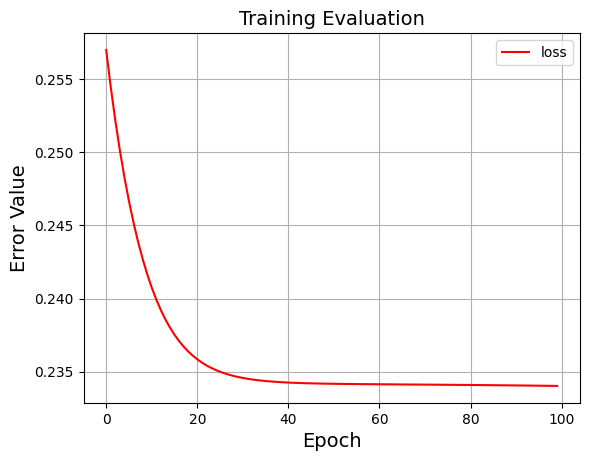

In [8]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [9]:
#Testing

#model = NeuralNetwork(30, 2)
# Test structure of model
y_test = torch.Tensor(y_test.values)
x_test = torch.Tensor(x_test.values)

predictions = model.forward(x_test)
preds = predictions.detach().cpu().numpy()

ohe = []
for i in preds:
       if i[0] > i[1]:
         ohe.append([1,0])
       else:
        ohe.append([0,1])
#preds
ohe

acc = accuracy_score(ohe, y_test)
cl_report = classification_report(ohe, y_test)
print("acc: ", acc)
print("cl report: ", cl_report)



acc:  0.631578947368421
cl report:                precision    recall  f1-score   support

           0       1.00      0.63      0.77       171
           1       0.00      0.00      0.00         0

   micro avg       0.63      0.63      0.63       171
   macro avg       0.50      0.32      0.39       171
weighted avg       1.00      0.63      0.77       171
 samples avg       0.63      0.63      0.63       171



D:\Data Engineering Class\Deep Learning\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
